In [1]:
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from PIL import Image
from keras.utils import plot_model
from IPython.display import Image 

# preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# modelling
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import utils
from keras import optimizers
from keras.models import Sequential
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.optimizers import SGD, Adam
from keras.applications.vgg19 import VGG19
from keras import losses
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
import math 

# callbacks
from keras.callbacks import History

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
IMAGE_PATH = "/content/gdrive/My Drive/Colab Notebooks/melanoma_classification/siim-isic-melanoma-classification/torch_jpeg/"

train_folder = os.path.join(IMAGE_PATH, 'train')
test_folder = os.path.join(IMAGE_PATH, 'test')


In [4]:
#train_benign = os.path.join(IMAGE_PATH + 'train' + '/', 'benign')
#test_benign = os.path.join(IMAGE_PATH + 'test' + '/', 'benign')
#files = os.listdir(train_benign)
#for f in files:
#  if np.random.rand(1) < .2:
#    shutil.move(train_benign + '/' + f, test_benign + '/' + f )

#train_malignant = os.path.join(IMAGE_PATH + 'train' + '/', 'malignant')
#test_malignant = os.path.join(IMAGE_PATH + 'test' + '/', 'malignant')
#files = os.listdir(train_malignant)
#for f in files:
#  if np.random.rand(1) < .2:
#    shutil.move(train_malignant + '/' + f, test_malignant + '/' + f )

In [5]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.3,
        rotation_range=30,
        horizontal_flip=True,
      #  vertical_flip=True,
        validation_split = 0.2)

# get all the data in the directory /train and reshape them
train_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=((64, 64)), 
       # color_mode = 'grayscale', 
        batch_size=2048,
        classes=['benign', 'malignant'])

# get all the data in the directory /train and reshape them
test_generator = train_datagen.flow_from_directory(
        test_folder, 
        target_size=(((64, 64))), 
       # color_mode = 'grayscale', 
        batch_size = 32,
        classes=['benign', 'malignant']
        ) 

# get all the data in the directory /val and reshape them
val_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(((64, 64))), 
       # color_mode = 'grayscale', 
        batch_size= 32,
        # class_mode='binary',
        subset='validation',
        classes=['benign', 'malignant'])




Found 9692 images belonging to 2 classes.
Found 3486 images belonging to 2 classes.
Found 1937 images belonging to 2 classes.


In [6]:
training_distribution = { x: len(os.listdir(train_folder +'/' + x)) for x in ['benign', 'malignant']}
test_distribution = { x: len(os.listdir(test_folder +'/' + x)) for x in ['benign', 'malignant']}

print(f"Number of benign images: {training_distribution}")
print(f"Number of benign images: {test_distribution}")

Number of benign images: {'benign': 5380, 'malignant': 4313}
Number of benign images: {'benign': 2441, 'malignant': 1046}


In [7]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

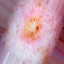

In [8]:
#@title Default title text

#preview training image
array_to_img(train_images[233])


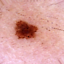

In [9]:
#preview training image
array_to_img(train_images[5])

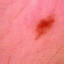

In [10]:
#preview training image
array_to_img(train_images[84])

In [11]:
# get shape of images in train and test

print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))
print(np.shape(val_images))
print(np.shape(val_labels))

(2048, 64, 64, 3)
(2048, 2)
(32, 64, 64, 3)
(32, 2)
(32, 64, 64, 3)
(32, 2)


In [12]:

# reshape images to contain dimensions into a single vector
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(2048, 12288)
(32, 12288)
(32, 12288)


In [13]:
# reshape images to contain dimensions into a single vector
train_y = np.reshape(train_labels[:,0], (2048,1))
test_y = np.reshape(test_labels[:,0], (32,1))
val_y = np.reshape(val_labels[:,0], (32,1))

In [14]:
#preview label to identify class valujes
train_labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [15]:

#identify the categorical values of 0 and 1
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [16]:
train_labels_final = train_labels.T[[1]]
np.shape(train_labels_final)


(1, 2048)

In [17]:
test_labels_final = test_labels.T[[1]]
np.shape(test_labels_final)

(1, 32)

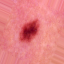

In [18]:
array_to_img(train_images[210])

In [19]:
train_labels_final[:,210]

array([0.], dtype=float32)

### Base CNN Model

In [20]:
np.random.seed(123)

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
 
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='softmax'))


base_model = models.Sequential()
base_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64,  3)))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))



base_model.add(layers.Flatten())
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))


opt = Adam(learning_rate=.001)

base_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
 
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='sgd',
#               metrics=['accuracy'])

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

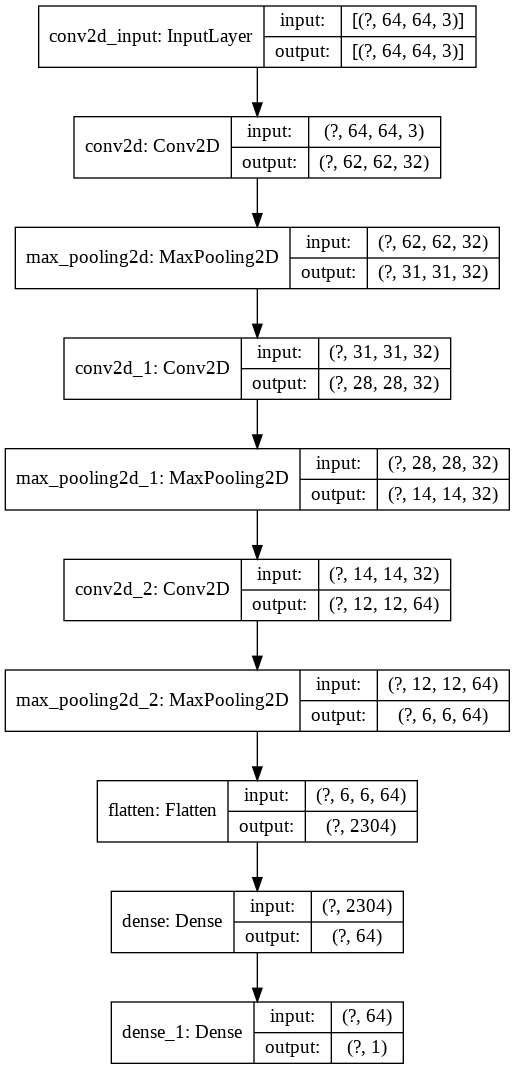

In [21]:
plot_model(base_model, show_shapes=True, show_layer_names=True)

In [22]:
history = base_model.fit(train_images,
          train_y,
          epochs=10,
          # batch_size=32,
          validation_data=(val_images, val_y))

Epoch 1/10
64/64 [==============================] - 7s 104ms/step - loss: 0.6939 - accuracy: 0.5298 - val_loss: 0.6966 - val_accuracy: 0.5938
Epoch 2/10
64/64 [==============================] - 6s 101ms/step - loss: 0.6888 - accuracy: 0.5347 - val_loss: 0.7105 - val_accuracy: 0.5938
Epoch 3/10
64/64 [==============================] - 7s 104ms/step - loss: 0.6860 - accuracy: 0.5474 - val_loss: 0.7221 - val_accuracy: 0.5625
Epoch 4/10
64/64 [==============================] - 7s 104ms/step - loss: 0.6833 - accuracy: 0.5820 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 5/10
64/64 [==============================] - 6s 100ms/step - loss: 0.6863 - accuracy: 0.5435 - val_loss: 0.7431 - val_accuracy: 0.5625
Epoch 6/10
64/64 [==============================] - 6s 100ms/step - loss: 0.6850 - accuracy: 0.5718 - val_loss: 0.7211 - val_accuracy: 0.5312
Epoch 7/10
64/64 [==============================] - 6s 99ms/step - loss: 0.6747 - accuracy: 0.5947 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 8

In [23]:
results_train = base_model.evaluate(train_images, train_y)

64/64 [==============================] - 2s 26ms/step - loss: 0.6610 - accuracy: 0.6030


In [24]:
results_test = base_model.evaluate(test_images, test_y)

1/1 [==============================] - 0s 1ms/step - loss: 0.6874 - accuracy: 0.5625


In [25]:
results_train

[0.6610426902770996, 0.60302734375]

In [26]:
results_test

[0.6874170303344727, 0.5625]

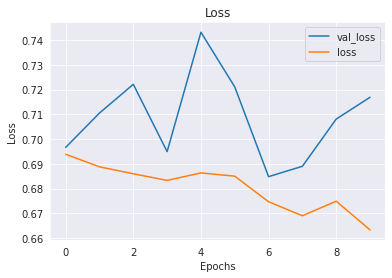

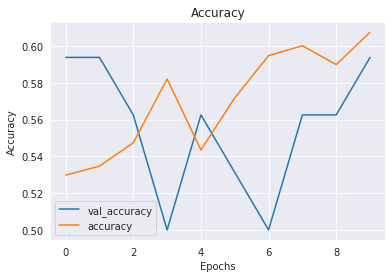

In [27]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

visualize_training_results(history)

### Model 2

In [28]:
np.random.seed(123)

base2_model = models.Sequential()
base2_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64,  3)))
base2_model.add(layers.MaxPooling2D((2, 2)))

base2_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
base2_model.add(layers.MaxPooling2D((2, 2)))

base2_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base2_model.add(layers.MaxPooling2D((2, 2)))
base2_model.add(layers.Flatten())
base2_model.add(layers.Dense(64, activation='relu'))
base2_model.add(layers.Dense(1, activation='sigmoid'))

base2_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy']) 

base2_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

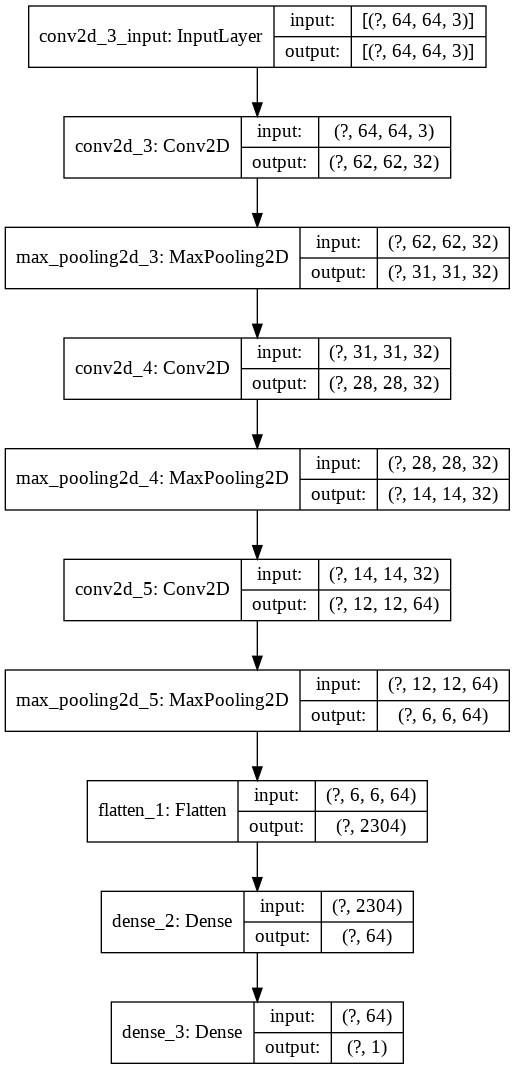

In [29]:
plot_model(base2_model, show_shapes=True, show_layer_names=True)

In [30]:
history = base2_model.fit(train_images,
          train_y,
          epochs=40,
          batch_size=64,
          validation_data=(val_images, val_y))

Epoch 1/40
64/64 [==============================] - 6s 101ms/step - loss: 0.6978 - accuracy: 0.5220 - val_loss: 0.6839 - val_accuracy: 0.5938
Epoch 2/40
64/64 [==============================] - 6s 98ms/step - loss: 0.6916 - accuracy: 0.5347 - val_loss: 0.6840 - val_accuracy: 0.5938
Epoch 3/40
64/64 [==============================] - 6s 98ms/step - loss: 0.6902 - accuracy: 0.5347 - val_loss: 0.6858 - val_accuracy: 0.5938
Epoch 4/40
64/64 [==============================] - 6s 97ms/step - loss: 0.6903 - accuracy: 0.5347 - val_loss: 0.6908 - val_accuracy: 0.5938
Epoch 5/40
64/64 [==============================] - 6s 97ms/step - loss: 0.6891 - accuracy: 0.5347 - val_loss: 0.6901 - val_accuracy: 0.5938
Epoch 6/40
64/64 [==============================] - 6s 98ms/step - loss: 0.6900 - accuracy: 0.5347 - val_loss: 0.6935 - val_accuracy: 0.5938
Epoch 7/40
64/64 [==============================] - 6s 98ms/step - loss: 0.6876 - accuracy: 0.5347 - val_loss: 0.7036 - val_accuracy: 0.5938
Epoch 8/40
6

In [31]:
results_train = base2_model.evaluate(train_images, train_y)

64/64 [==============================] - 2s 26ms/step - loss: 0.4000 - accuracy: 0.7930


In [32]:
results_test = base2_model.evaluate(test_images, test_y)

1/1 [==============================] - 0s 2ms/step - loss: 0.6576 - accuracy: 0.7188


In [33]:
results_train

[0.3999699056148529, 0.79296875]

In [34]:
results_test

[0.657586932182312, 0.71875]

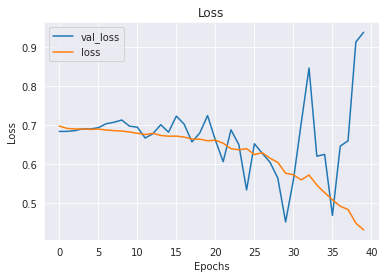

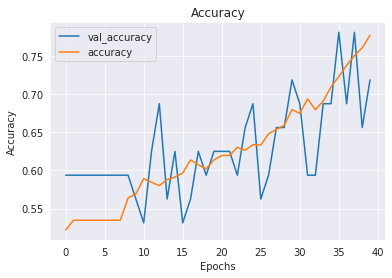

In [35]:
visualize_training_results(history)

